Students:

- Ben Kabongo, M1 DS, 22210136

# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    #!wget http://deeplearning.net/data/mnist/mnist.pkl.gz
    !wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

--2023-04-02 09:39:28--  https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz [following]
--2023-04-02 09:39:29--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M  --.-KB/s    in 0.1s    

2023-04-02 09:39:30 (111 MB/s) 

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 2


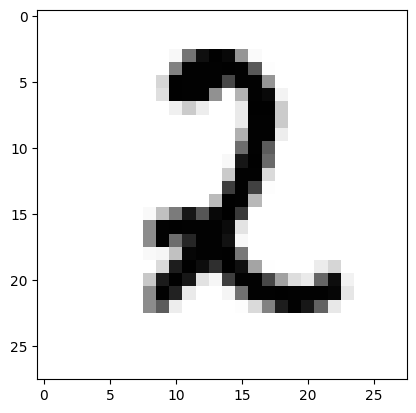

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [25]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g

        if self.d is None:
            raise RuntimeError("Backward function not defined!")
        if self.backptr is None:
            raise RuntimeError("Backward graph not defined!")
        if self.gradient is None:
            raise RuntimeError("Gradient not defined!")
        
        self.d(self.backptr, self.gradient)
        for node in self.backptr:
            if isinstance(node, Tensor) and node.require_grad:
                node.backward()

In [6]:
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [7]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [8]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [9]:
def tanh(x):
    v = np.tanh(x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_tanh
    output.backptr = [x]
    
    return output

def backward_tanh(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        grad = g * (1 - np.tanh(x.data) ** 2)
        x.accumulate_gradient(grad)

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [23]:
def affine_transform(W, b, x):
    z = W.data @ x.data + b.data
    
    output = Tensor(z, require_grad=any_require_grad([W, b, x]))
    output.backptr = [W, b, x]
    output.d = backward_affine_transform
    
    return output

def backward_affine_transform(backptr, g):
    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(np.outer(g, x.data))
    if b.require_grad:
        b.accumulate_gradient(g)
    if isinstance(x, Tensor) and x.require_grad:
        x.accumulate_gradient(W.data.T @ g)


In [21]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    x = np.array(x)
    exp = np.exp(x-x.max())
    return exp / exp.sum()

def nll(x, gold):
    v = -np.log(_softmax(x.data)[gold])

    output = Tensor(v, require_grad=x.require_grad)
    output.backptr = [x, gold]
    output.d = backward_nll

    return output

def backward_nll(backptr, g):
    x, gold = backptr

    if x.require_grad:
        mask = np.zeros(x.data.shape)
        mask[gold] = 1
        g_x = (_softmax(x.data) - mask) * g
        x.accumulate_gradient(g_x)

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [13]:
class Module:
    def __init__(self):
        raise NotImplemented("")
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [14]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    n_in, n_out = W.shape
    std = np.sqrt(2.0 / (n_in + n_out))
    W[:] = np.random.normal(0, std, size=(n_in, n_out))
    
# Look at slides for the formula!
def kaiming_init(W):
    n_in, n_out = W.shape
    std = np.sqrt(2.0 / n_in)
    W[:] = np.random.normal(0, std, size=(n_in, n_out))

In [15]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [16]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
        self.b = Parameter(np.ndarray((dim_output,)), name="b")
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [50]:
import math

def training_loop(network, optimizer, train_data, dev_data, n_epochs=10):
    best_dev = -math.inf
    idx = np.arange(0, len(train_data[1]))

    all_loss = []
    all_valid_acc = []

    for epoch in range(n_epochs):
        np.random.shuffle(idx)

        # train
        loss = 0
        for i in idx:
            x = train_data[0][i]
            y = train_data[1][i]
            x_t = Tensor(x)
            # forward
            z = network.forward(x_t)
            loss_tensor = nll(z, y)
            loss += loss_tensor.data[0]
            # zero grad
            optimizer.zero_grad()
            # backward
            loss_tensor.backward(.1)
            # update
            optimizer.step()

        # eval
        dev_acc = 0
        for i in range(len(dev_data[1])):
            x = dev_data[0][i]
            y = dev_data[1][i]
            x_t = Tensor(x)
            # predict
            y_pred = network.forward(x_t).data.argmax()
            dev_acc += int(y_pred == y)
        dev_acc /= len(dev_data[1])
        print(f'Epoch {epoch + 1} : \tTrain Loss : {loss} \tValid Acc: {dev_acc}')
        all_loss.append(loss)
        all_valid_acc.append(dev_acc)

        if dev_acc > best_dev:
            best_dev = dev_acc
            optimizer.best_params = list(optimizer.params)

    return all_loss, all_valid_acc

In [36]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=10)
print()

Epoch 1 : Train Loss : 29068.98871847551 Valid Acc: 0.8983
Epoch 2 : Train Loss : 18860.45046476075 Valid Acc: 0.9096
Epoch 3 : Train Loss : 17247.85263047583 Valid Acc: 0.9143
Epoch 4 : Train Loss : 16415.73393066116 Valid Acc: 0.9159
Epoch 5 : Train Loss : 15876.278994169326 Valid Acc: 0.9173
Epoch 6 : Train Loss : 15489.482653592671 Valid Acc: 0.9192
Epoch 7 : Train Loss : 15200.253822401055 Valid Acc: 0.9199
Epoch 8 : Train Loss : 14968.22892280655 Valid Acc: 0.9213
Epoch 9 : Train Loss : 14781.652122094682 Valid Acc: 0.9213
Epoch 10 : Train Loss : 14615.645758038707 Valid Acc: 0.9214


In [40]:
for param in optimizer.best_params:
    print(param.name, param.data.shape)

W (10, 784)
b (10,)


In [41]:
# Test evaluation
network = LinearNetwork(dim_input, dim_output)
network.W = optimizer.best_params[0]
network.b = optimizer.best_params[1]

test_acc = 0
for i in range(len(test_data[1])):
    x = test_data[0][i]
    y = test_data[1][i]
    x_t = Tensor(x)
    y_pred = affine_transform(optimizer.best_params[0], optimizer.best_params[1], x_t).data.argmax()
    test_acc += int(y_pred == y)
test_acc /= len(dev_data[1])
print(f'Test acc {test_acc}')

Test acc 0.9213


After you finished the linear network, you can move to a deep network!

In [81]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, use_tanh=False):
        self.W = ModuleList()
        self.b = ModuleList()
        
        assert n_layers >= 1
        self.n_layers = n_layers
        self.activation = tanh if use_tanh else relu

        self.W.append(Parameter(np.ndarray((hidden_dim, dim_input)), name="W1"))
        self.b.append(Parameter(np.ndarray((hidden_dim,)), name="b1"))

        for i in range(2, n_layers+1):
            self.W.append(Parameter(np.ndarray((hidden_dim, hidden_dim)), name=f"W{i}"))
            self.b.append(Parameter(np.ndarray((hidden_dim,)), name=f"b{i}"))
        
        self.output_proj = Parameter(np.ndarray((dim_output, hidden_dim)), name=f"W{n_layers+1}")
        self.output_bias = Parameter(np.ndarray((dim_output,)), name=f"b{n_layers+1}")
        
        self.init_parameters()
        
    def init_parameters(self):
        for i in range(self.n_layers):
            glorot_init(self.W[i].data)
            zero_init(self.b[i].data)
        glorot_init(self.output_proj.data)
        zero_init(self.output_bias.data)

    def forward(self, x):
        for i in range(self.n_layers):
            x = affine_transform(self.W[i], self.b[i], x)
            x = self.activation(x)
        x = affine_transform(self.output_proj, self.output_bias, x)
        return x

In [82]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)
print()

Epoch 1 : 	Train Loss : 22171.46697277118 	Valid Acc: 0.9322
Epoch 2 : 	Train Loss : 10892.384879104575 	Valid Acc: 0.9462
Epoch 3 : 	Train Loss : 8321.489647385419 	Valid Acc: 0.9584
Epoch 4 : 	Train Loss : 6778.5268871343105 	Valid Acc: 0.9629
Epoch 5 : 	Train Loss : 5673.16213920616 	Valid Acc: 0.9658



In [83]:
for param in optimizer.best_params:
    print(param.name, param.data.shape)

W1 (100, 784)
W2 (100, 100)
b1 (100,)
b2 (100,)
b3 (10,)
W3 (10, 100)


In [84]:
# Test evaluation
network = DeepNetwork(dim_input, dim_output, 100, 2)
network.W = optimizer.best_params[:2]
network.b = optimizer.best_params[2:4]
network.output_bias = optimizer.best_params[4]
network.output_proj = optimizer.best_params[5]

test_acc = 0
for i in range(len(test_data[1])):
    x = test_data[0][i]
    y = test_data[1][i]
    x_t = Tensor(x)
    y_pred = network.forward(x_t).data.argmax()
    test_acc += int(y_pred == y)
test_acc /= len(dev_data[1])
print(f'Test acc {test_acc}')

Test acc 0.9657


In [85]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2, True)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)
print()

Epoch 1 : 	Train Loss : 21583.984706758944 	Valid Acc: 0.9248
Epoch 2 : 	Train Loss : 12517.106021285652 	Valid Acc: 0.9411
Epoch 3 : 	Train Loss : 9853.713477182133 	Valid Acc: 0.9503
Epoch 4 : 	Train Loss : 8092.910983742708 	Valid Acc: 0.958
Epoch 5 : 	Train Loss : 6880.557403553483 	Valid Acc: 0.9625



In [86]:
for param in optimizer.best_params:
    print(param.name, param.data.shape)

W1 (100, 784)
W2 (100, 100)
b1 (100,)
b2 (100,)
b3 (10,)
W3 (10, 100)


In [87]:
# Test evaluation
network = DeepNetwork(dim_input, dim_output, 100, 2, True)
network.W = optimizer.best_params[:2]
network.b = optimizer.best_params[2:4]
network.output_bias = optimizer.best_params[4]
network.output_proj = optimizer.best_params[5]

test_acc = 0
for i in range(len(test_data[1])):
    x = test_data[0][i]
    y = test_data[1][i]
    x_t = Tensor(x)
    y_pred = network.forward(x_t).data.argmax()
    test_acc += int(y_pred == y)
test_acc /= len(dev_data[1])
print(f'Test acc {test_acc}')

Test acc 0.96


In [88]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 5, True)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)
print()

Epoch 1 : 	Train Loss : 19435.74628390679 	Valid Acc: 0.9397
Epoch 2 : 	Train Loss : 9696.165153527663 	Valid Acc: 0.9507
Epoch 3 : 	Train Loss : 7071.185631638499 	Valid Acc: 0.962
Epoch 4 : 	Train Loss : 5636.0912492468515 	Valid Acc: 0.9646
Epoch 5 : 	Train Loss : 4643.508443987396 	Valid Acc: 0.9696



In [90]:
for param in optimizer.best_params:
    print(param.name, param.data.shape)

W1 (100, 784)
W2 (100, 100)
W3 (100, 100)
W4 (100, 100)
W5 (100, 100)
b1 (100,)
b2 (100,)
b3 (100,)
b4 (100,)
b5 (100,)
b6 (10,)
W6 (10, 100)


In [91]:
# Test evaluation
network = DeepNetwork(dim_input, dim_output, 100, 5, True)
network.W = optimizer.best_params[:5]
network.b = optimizer.best_params[5:10]
network.output_bias = optimizer.best_params[10]
network.output_proj = optimizer.best_params[11]

test_acc = 0
for i in range(len(test_data[1])):
    x = test_data[0][i]
    y = test_data[1][i]
    x_t = Tensor(x)
    y_pred = network.forward(x_t).data.argmax()
    test_acc += int(y_pred == y)
test_acc /= len(dev_data[1])
print(f'Test acc {test_acc}')

Test acc 0.9679


## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.


## Experimentations

In [51]:
# linear
def linear(lr=.01, n_epochs=5):
    print(f'\nlr={lr} n_epochs={n_epochs} -------------------------------')

    dim_input = 28*28
    dim_output = 10

    network = LinearNetwork(dim_input, dim_output)
    optimizer = SGD(network.parameters(), lr)

    all_loss, all_valid_acc = training_loop(network, optimizer, train_data, dev_data, n_epochs=n_epochs)
    
    # Test evaluation
    network = LinearNetwork(dim_input, dim_output)
    network.W = optimizer.best_params[0]
    network.b = optimizer.best_params[1]

    test_acc = 0
    for i in range(len(test_data[1])):
        x = test_data[0][i]
        y = test_data[1][i]
        x_t = Tensor(x)
        y_pred = affine_transform(optimizer.best_params[0], optimizer.best_params[1], x_t).data.argmax()
        test_acc += int(y_pred == y)
    test_acc /= len(dev_data[1])
    print(f'Test acc : {test_acc}')

    return all_loss, all_valid_acc, test_acc

In [52]:
# learning rate

lrs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
n_epochs = 10

all_loss_lrs = []
all_valid_acc_lrs = []
all_test_acc_lrs = []

for lr in lrs:
    all_loss, all_valid_acc, test_acc = linear(lr=lr, n_epochs=n_epochs)
    all_loss_lrs.append(all_loss)
    all_valid_acc_lrs.append(all_valid_acc)
    all_test_acc_lrs.append(test_acc)
    print()


lr=0.0001 n_epochs=10 -------------------------------
Epoch 1 : 	Train Loss : 109022.63578619731 	Valid Acc: 0.4402
Epoch 2 : 	Train Loss : 89624.38941943247 	Valid Acc: 0.6339
Epoch 3 : 	Train Loss : 76280.33474815168 	Valid Acc: 0.7222
Epoch 4 : 	Train Loss : 66815.54572846869 	Valid Acc: 0.7664
Epoch 5 : 	Train Loss : 59915.17695082518 	Valid Acc: 0.7931
Epoch 6 : 	Train Loss : 54725.58238986469 	Valid Acc: 0.81
Epoch 7 : 	Train Loss : 50704.457926513925 	Valid Acc: 0.8207
Epoch 8 : 	Train Loss : 47505.10214723649 	Valid Acc: 0.8347
Epoch 9 : 	Train Loss : 44900.87111540883 	Valid Acc: 0.8401
Epoch 10 : 	Train Loss : 42738.858236475506 	Valid Acc: 0.846
Test acc : 0.8342


lr=0.001 n_epochs=10 -------------------------------
Epoch 1 : 	Train Loss : 63782.88784221948 	Valid Acc: 0.8433
Epoch 2 : 	Train Loss : 35602.107322731375 	Valid Acc: 0.8703
Epoch 3 : 	Train Loss : 29258.258966830625 	Valid Acc: 0.8804
Epoch 4 : 	Train Loss : 26215.734413145827 	Valid Acc: 0.8887
Epoch 5 : 	Tra

<ipython-input-21-5decd553a3a7>:9: RuntimeWarning: divide by zero encountered in log
  v = -np.log(_softmax(x.data)[gold])


Epoch 1 : 	Train Loss : inf 	Valid Acc: 0.8848
Epoch 2 : 	Train Loss : 496284.5597976448 	Valid Acc: 0.8802
Epoch 3 : 	Train Loss : inf 	Valid Acc: 0.8875
Epoch 4 : 	Train Loss : 475417.39596608473 	Valid Acc: 0.8817
Epoch 5 : 	Train Loss : 468228.5151574253 	Valid Acc: 0.8955
Epoch 6 : 	Train Loss : 465073.0248186896 	Valid Acc: 0.8793
Epoch 7 : 	Train Loss : inf 	Valid Acc: 0.8631
Epoch 8 : 	Train Loss : 456330.0335854517 	Valid Acc: 0.8825
Epoch 9 : 	Train Loss : inf 	Valid Acc: 0.8836
Epoch 10 : 	Train Loss : inf 	Valid Acc: 0.907
Test acc : 0.8992



In [53]:
all_loss_lrs = np.array(all_loss_lrs)
all_valid_acc_lrs = np.array(all_valid_acc_lrs)
all_test_acc_lrs = np.array(all_test_acc_lrs)

In [55]:
plt.style.use('seaborn-whitegrid')

<ipython-input-55-adcf1482bdd0>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


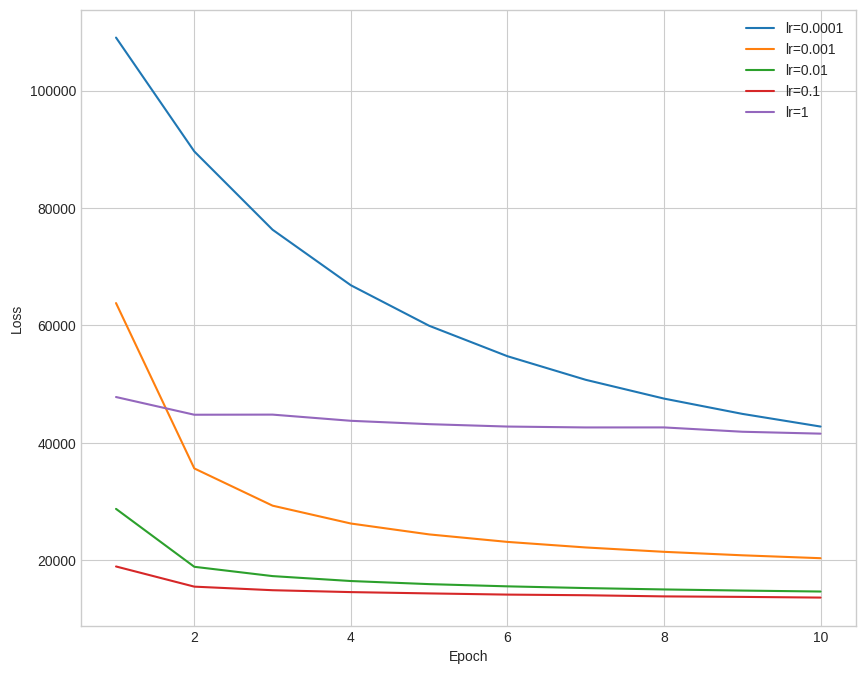

In [57]:
# lr loss
plt.figure(figsize=(10, 8))
for i, lr in enumerate(lrs[:-1]):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_lrs[i], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

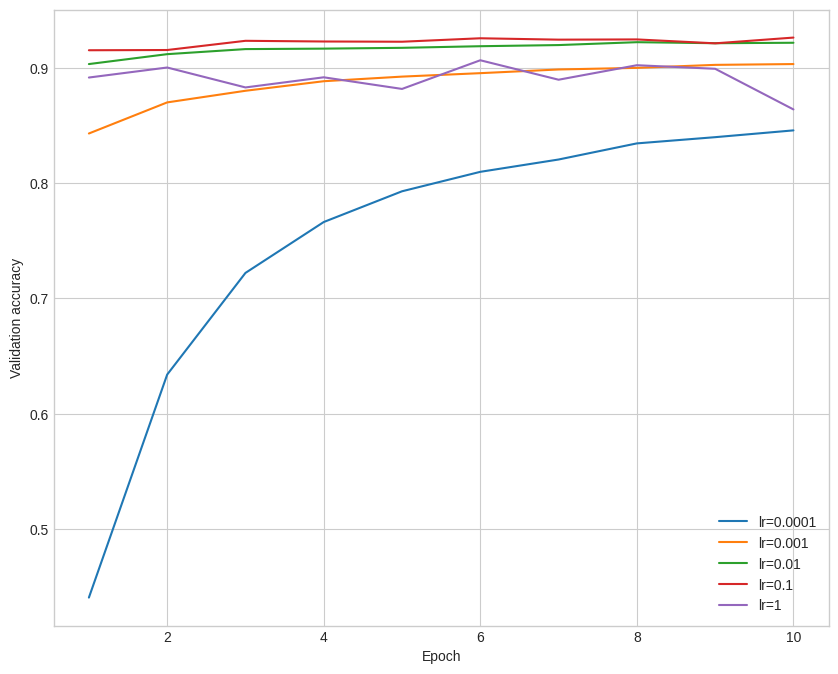

In [58]:
# lr validation accuracy
plt.figure(figsize=(10, 8))
for i, lr in enumerate(lrs[:-1]):
    plt.plot(np.arange(1, 1 + n_epochs), all_valid_acc_lrs[i], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

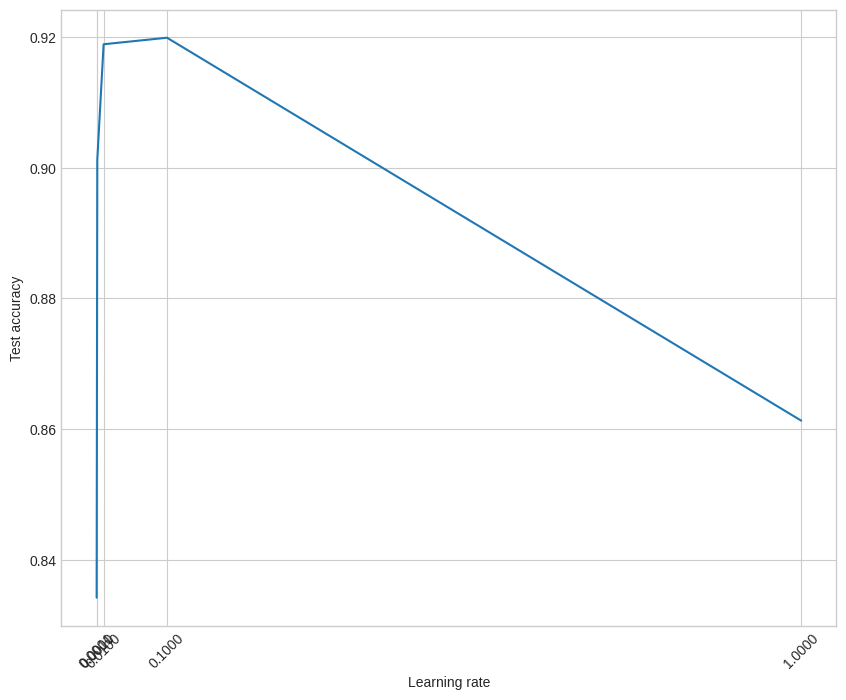

In [65]:
# lr test accuracy
plt.figure(figsize=(10, 8))
plt.plot(lrs[:-1], all_test_acc_lrs[:-1])
plt.xlabel('Learning rate')
plt.ylabel('Test accuracy')
plt.xticks(lrs[:-1], rotation=45)
plt.show()

In [67]:
# nb of epochs

lr = 1e-2
ns_epochs = [2, 5, 10, 20]

all_test_acc_n_epochs = []

for n_epochs in ns_epochs:
    _, _, test_acc = linear(lr=lr, n_epochs=n_epochs)
    all_test_acc_n_epochs.append(test_acc)
    print()


lr=0.01 n_epochs=2 -------------------------------
Epoch 1 : 	Train Loss : 28797.90353481066 	Valid Acc: 0.9036
Epoch 2 : 	Train Loss : 18834.56386624355 	Valid Acc: 0.9106
Test acc : 0.9087


lr=0.01 n_epochs=5 -------------------------------
Epoch 1 : 	Train Loss : 28791.57216049717 	Valid Acc: 0.8984
Epoch 2 : 	Train Loss : 18827.959531718432 	Valid Acc: 0.909
Epoch 3 : 	Train Loss : 17241.763600454797 	Valid Acc: 0.9154
Epoch 4 : 	Train Loss : 16411.050134451587 	Valid Acc: 0.9178
Epoch 5 : 	Train Loss : 15887.925718404675 	Valid Acc: 0.918
Test acc : 0.9166


lr=0.01 n_epochs=10 -------------------------------
Epoch 1 : 	Train Loss : 28834.042416635686 	Valid Acc: 0.9028
Epoch 2 : 	Train Loss : 18845.939783111102 	Valid Acc: 0.9106
Epoch 3 : 	Train Loss : 17251.410044178545 	Valid Acc: 0.9158
Epoch 4 : 	Train Loss : 16429.246275183563 	Valid Acc: 0.918
Epoch 5 : 	Train Loss : 15900.498302042968 	Valid Acc: 0.9178
Epoch 6 : 	Train Loss : 15510.213447719094 	Valid Acc: 0.92
Epoch 7

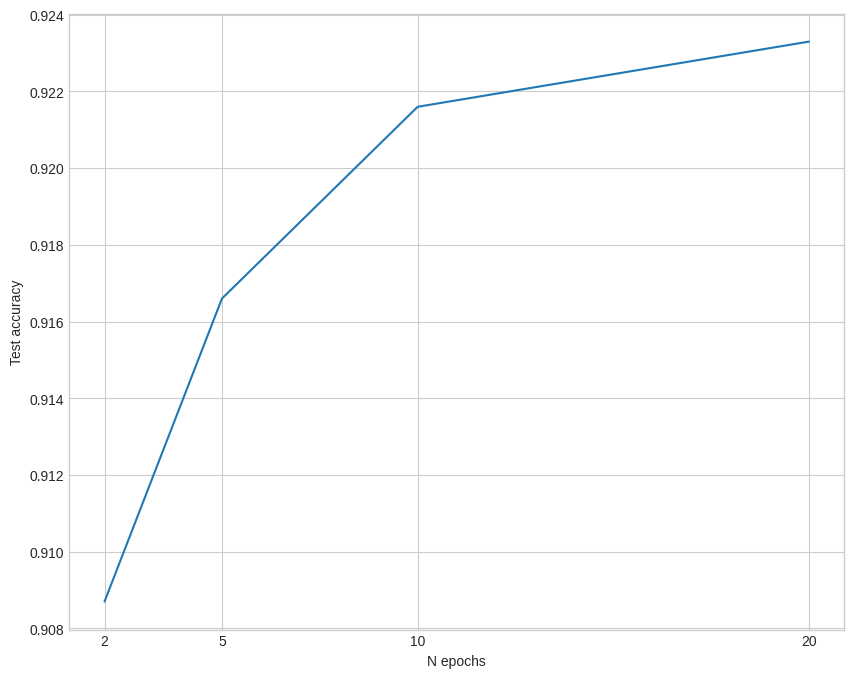

In [68]:
# n_epochs test accuracy
plt.figure(figsize=(10, 8))
plt.plot(ns_epochs, all_test_acc_n_epochs)
plt.xlabel('N epochs')
plt.ylabel('Test accuracy')
plt.xticks(ns_epochs)
plt.show()

In [92]:
# deep
def deep(lr=.01, n_epochs=5, hidden_dim=100, n_layers=2, use_tanh=False):
    print(f'\nlr={lr} n_epochs={n_epochs} hidden_dim={hidden_dim} n_layers={n_layers} tanh={use_tanh}')
    print('-----------------------------------------------')

    dim_input = 28*28
    dim_output = 10

    network = DeepNetwork(dim_input, dim_output, hidden_dim, n_layers, use_tanh)
    optimizer = SGD(network.parameters(), lr)

    all_loss, all_valid_acc = training_loop(network, optimizer, train_data, dev_data, n_epochs=n_epochs)
    
    # Test evaluation
    network = DeepNetwork(dim_input, dim_output, hidden_dim, n_layers, use_tanh)
    network.W = optimizer.best_params[:n_layers]
    network.b = optimizer.best_params[n_layers:2*n_layers]
    network.output_bias = optimizer.best_params[2*n_layers]
    network.output_proj = optimizer.best_params[2*n_layers+1]

    test_acc = 0
    for i in range(len(test_data[1])):
        x = test_data[0][i]
        y = test_data[1][i]
        x_t = Tensor(x)
        y_pred = network.forward(x_t).data.argmax()
        test_acc += int(y_pred == y)
    test_acc /= len(dev_data[1])
    print(f'Test acc {test_acc}')

    return all_loss, all_valid_acc, test_acc

In [93]:
# learning rate

lrs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
n_epochs = 5
hidden_dim = 100
n_layers = 2
use_tanh = False

all_loss_lrs = []
all_valid_acc_lrs = []
all_test_acc_lrs = []

for lr in lrs:
    all_loss, all_valid_acc, test_acc = deep(lr=lr, n_epochs=n_epochs, hidden_dim=hidden_dim, n_layers=n_layers, use_tanh=use_tanh)
    all_loss_lrs.append(all_loss)
    all_valid_acc_lrs.append(all_valid_acc)
    all_test_acc_lrs.append(test_acc)
    print()


lr=0.0001 n_epochs=5 hidden_dim=100 n_layers=2 tanh=False
-----------------------------------------------
Epoch 1 : 	Train Loss : 111406.77042895772 	Valid Acc: 0.3382
Epoch 2 : 	Train Loss : 100256.4951036916 	Valid Acc: 0.5334
Epoch 3 : 	Train Loss : 88215.85180210455 	Valid Acc: 0.6465
Epoch 4 : 	Train Loss : 75408.31409287988 	Valid Acc: 0.7203
Epoch 5 : 	Train Loss : 63377.482368324185 	Valid Acc: 0.7785
Test acc 0.7669


lr=0.001 n_epochs=5 hidden_dim=100 n_layers=2 tanh=False
-----------------------------------------------
Epoch 1 : 	Train Loss : 64553.75099165822 	Valid Acc: 0.8609
Epoch 2 : 	Train Loss : 25785.375419607866 	Valid Acc: 0.8951
Epoch 3 : 	Train Loss : 19803.487973697196 	Valid Acc: 0.9067
Epoch 4 : 	Train Loss : 17356.60784722809 	Valid Acc: 0.9155
Epoch 5 : 	Train Loss : 15904.85949310041 	Valid Acc: 0.9209
Test acc 0.9172


lr=0.01 n_epochs=5 hidden_dim=100 n_layers=2 tanh=False
-----------------------------------------------
Epoch 1 : 	Train Loss : 21960.3794

<ipython-input-21-5decd553a3a7>:9: RuntimeWarning: divide by zero encountered in log
  v = -np.log(_softmax(x.data)[gold])


Epoch 1 : 	Train Loss : inf 	Valid Acc: 0.109
Epoch 2 : 	Train Loss : 127052.46342292323 	Valid Acc: 0.0991
Epoch 3 : 	Train Loss : 127016.43490298084 	Valid Acc: 0.1009
Epoch 4 : 	Train Loss : 126961.50839258225 	Valid Acc: 0.0983
Epoch 5 : 	Train Loss : 127103.11567164552 	Valid Acc: 0.109
Test acc 0.1028



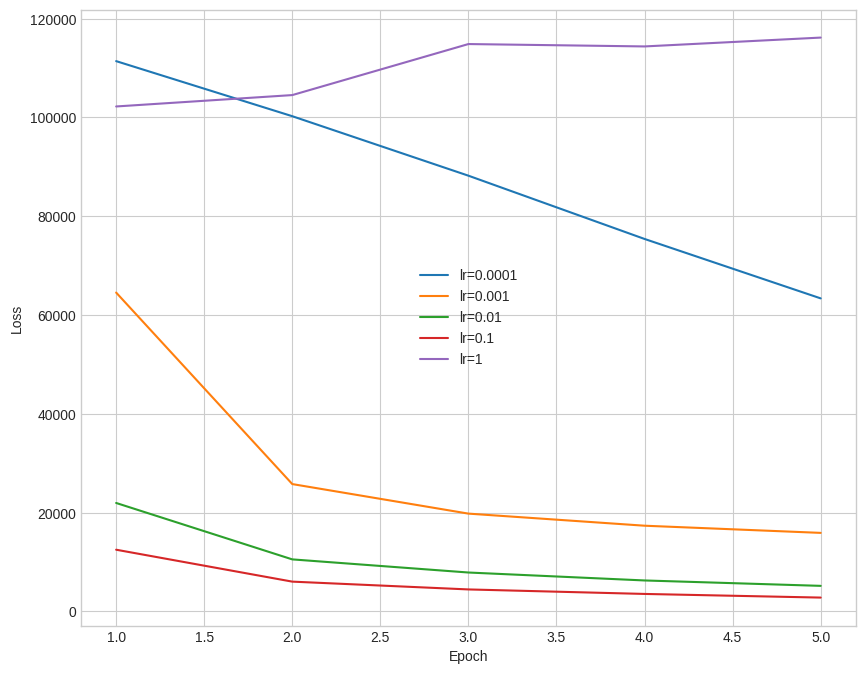

In [94]:
# lr loss
plt.figure(figsize=(10, 8))
for i, lr in enumerate(lrs[:-1]):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_lrs[i], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [105]:
# n_layers

lr = 1e-2
n_epochs = 10
hidden_dim = 100
ns_layers = [2, 3, 4, 5, 6]
use_tanh = True

all_loss_ns_layers = []
all_valid_acc_ns_layers = []
all_test_acc_ns_layers = []

for n_layers in ns_layers:
    all_loss, all_valid_acc, test_acc = deep(lr=lr, n_epochs=n_epochs, hidden_dim=hidden_dim, n_layers=n_layers, use_tanh=use_tanh)
    all_loss_ns_layers.append(all_loss)
    all_valid_acc_ns_layers.append(all_valid_acc)
    all_test_acc_ns_layers.append(test_acc)
    print()


lr=0.01 n_epochs=10 hidden_dim=100 n_layers=2 tanh=True
-----------------------------------------------
Epoch 1 : 	Train Loss : 21361.14847621595 	Valid Acc: 0.9206
Epoch 2 : 	Train Loss : 12612.405288944896 	Valid Acc: 0.9388
Epoch 3 : 	Train Loss : 9964.407922410819 	Valid Acc: 0.9507
Epoch 4 : 	Train Loss : 8177.26180583719 	Valid Acc: 0.9575
Epoch 5 : 	Train Loss : 6922.412309556951 	Valid Acc: 0.9611
Epoch 6 : 	Train Loss : 5971.691140024779 	Valid Acc: 0.9654
Epoch 7 : 	Train Loss : 5205.917468327556 	Valid Acc: 0.9672
Epoch 8 : 	Train Loss : 4633.986199649867 	Valid Acc: 0.9702
Epoch 9 : 	Train Loss : 4129.120366506815 	Valid Acc: 0.9703
Epoch 10 : 	Train Loss : 3718.1158150514198 	Valid Acc: 0.9717
Test acc 0.969


lr=0.01 n_epochs=10 hidden_dim=100 n_layers=3 tanh=True
-----------------------------------------------
Epoch 1 : 	Train Loss : 20425.438865824894 	Valid Acc: 0.9329
Epoch 2 : 	Train Loss : 11030.419649173731 	Valid Acc: 0.949
Epoch 3 : 	Train Loss : 8231.0598967000

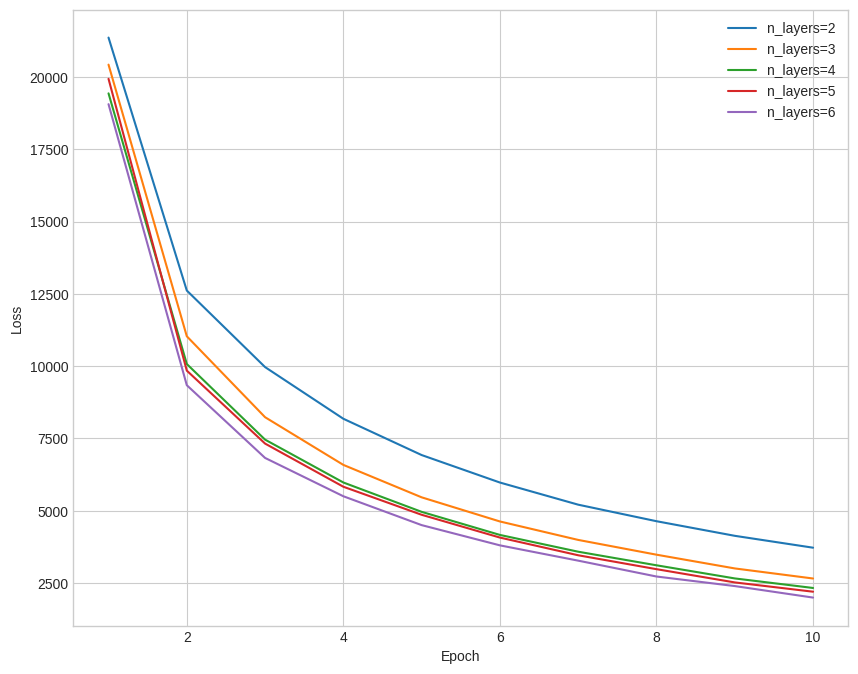

In [106]:
# n_layers loss
plt.figure(figsize=(10, 8))
for i, n_layers in enumerate(ns_layers):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_ns_layers[i], label=f'n_layers={n_layers}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

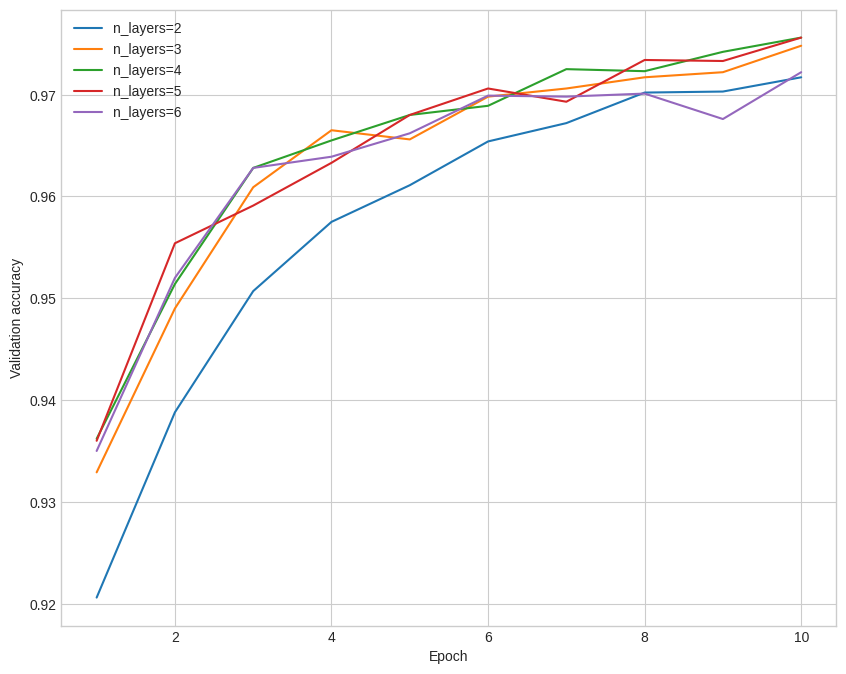

In [107]:
# n_layers loss
plt.figure(figsize=(10, 8))
for i, n_layers in enumerate(ns_layers):
    plt.plot(np.arange(1, 1 + n_epochs), all_valid_acc_ns_layers[i], label=f'n_layers={n_layers}')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

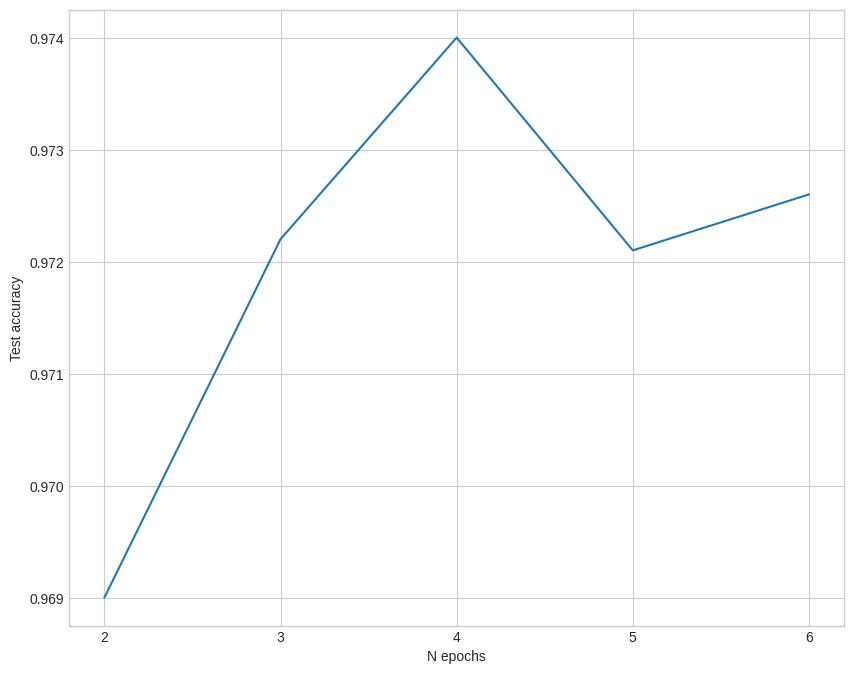

In [108]:
# n_layers test accuracy
plt.figure(figsize=(10, 8))
plt.plot(ns_layers, all_test_acc_ns_layers)
plt.xlabel('N epochs')
plt.ylabel('Test accuracy')
plt.xticks(ns_layers)
plt.show()

In [101]:
# hidden_dim

lr = 1e-2
n_epochs = 10
hidden_dims = [10, 20, 50, 100, 200]
n_layers = 3
use_tanh = True

all_loss_hidden_dims = []
all_valid_acc_hidden_dims = []
all_test_acc_hidden_dims = []

for hidden_dim in hidden_dims:
    all_loss, all_valid_acc, test_acc = deep(lr=lr, n_epochs=n_epochs, hidden_dim=hidden_dim, n_layers=n_layers, use_tanh=use_tanh)
    all_loss_hidden_dims.append(all_loss)
    all_valid_acc_hidden_dims.append(all_valid_acc)
    all_test_acc_hidden_dims.append(test_acc)
    print()


lr=0.01 n_epochs=10 hidden_dim=10 n_layers=3 tanh=True
-----------------------------------------------
Epoch 1 : 	Train Loss : 40836.13303640891 	Valid Acc: 0.888
Epoch 2 : 	Train Loss : 19078.506005924333 	Valid Acc: 0.9106
Epoch 3 : 	Train Loss : 16278.826939992448 	Valid Acc: 0.9177
Epoch 4 : 	Train Loss : 15063.07051695526 	Valid Acc: 0.9243
Epoch 5 : 	Train Loss : 14165.713278414836 	Valid Acc: 0.9265
Epoch 6 : 	Train Loss : 13543.550955135219 	Valid Acc: 0.9271
Epoch 7 : 	Train Loss : 13025.51336862757 	Valid Acc: 0.93
Epoch 8 : 	Train Loss : 12623.528781146359 	Valid Acc: 0.9294
Epoch 9 : 	Train Loss : 12250.826518034917 	Valid Acc: 0.9312
Epoch 10 : 	Train Loss : 11889.002893132085 	Valid Acc: 0.9343
Test acc 0.9286


lr=0.01 n_epochs=10 hidden_dim=20 n_layers=3 tanh=True
-----------------------------------------------
Epoch 1 : 	Train Loss : 28470.931233790743 	Valid Acc: 0.9217
Epoch 2 : 	Train Loss : 12986.38608374439 	Valid Acc: 0.9436
Epoch 3 : 	Train Loss : 10207.8353583

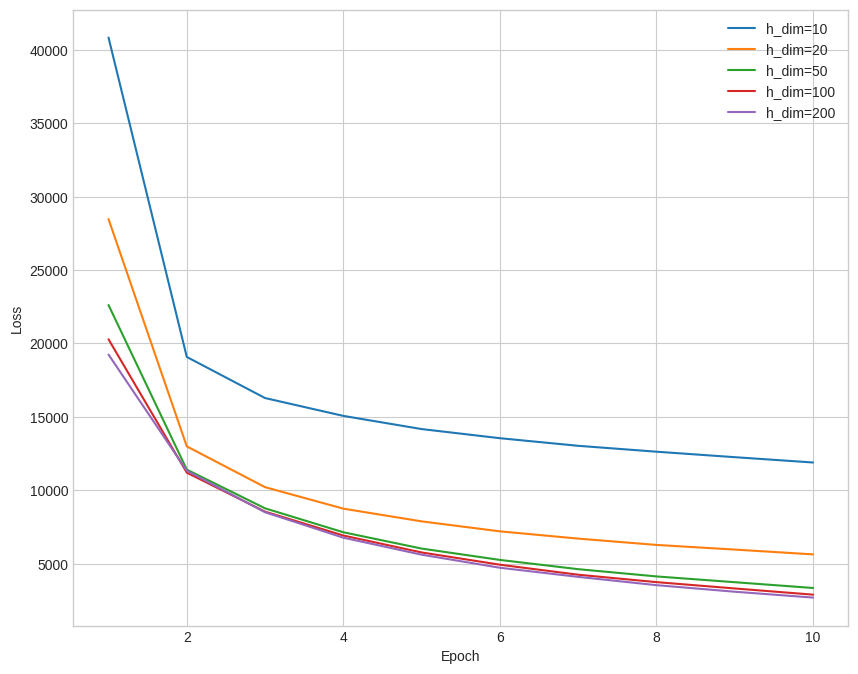

In [102]:
# hidden_dim loss
plt.figure(figsize=(10, 8))
for i, hidden_dim in enumerate(hidden_dims):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_hidden_dims[i], label=f'h_dim={hidden_dim}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

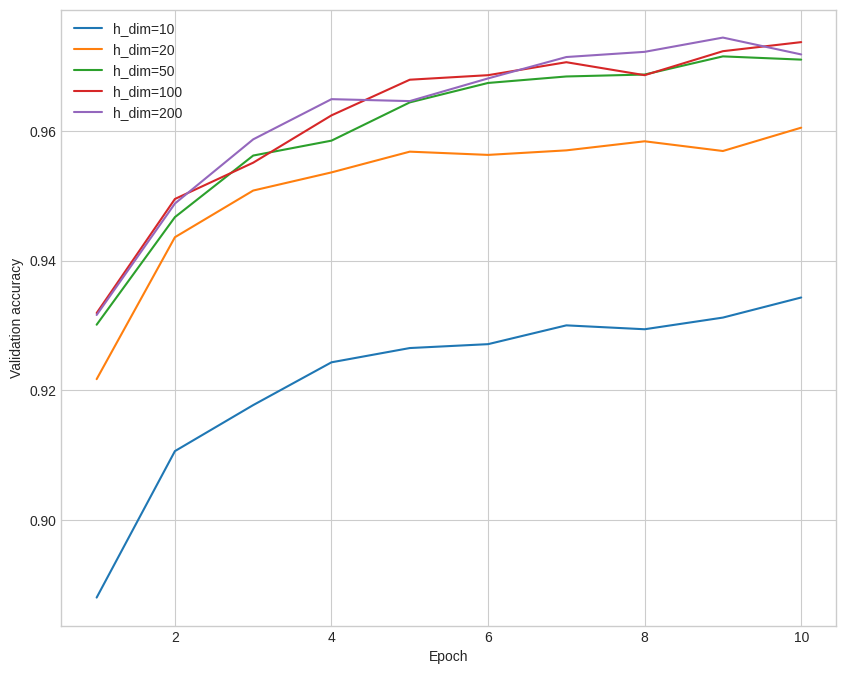

In [103]:
# hidden_dim loss
plt.figure(figsize=(10, 8))
for i, hidden_dim in enumerate(hidden_dims):
    plt.plot(np.arange(1, 1 + n_epochs), all_valid_acc_hidden_dims[i], label=f'h_dim={hidden_dim}')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

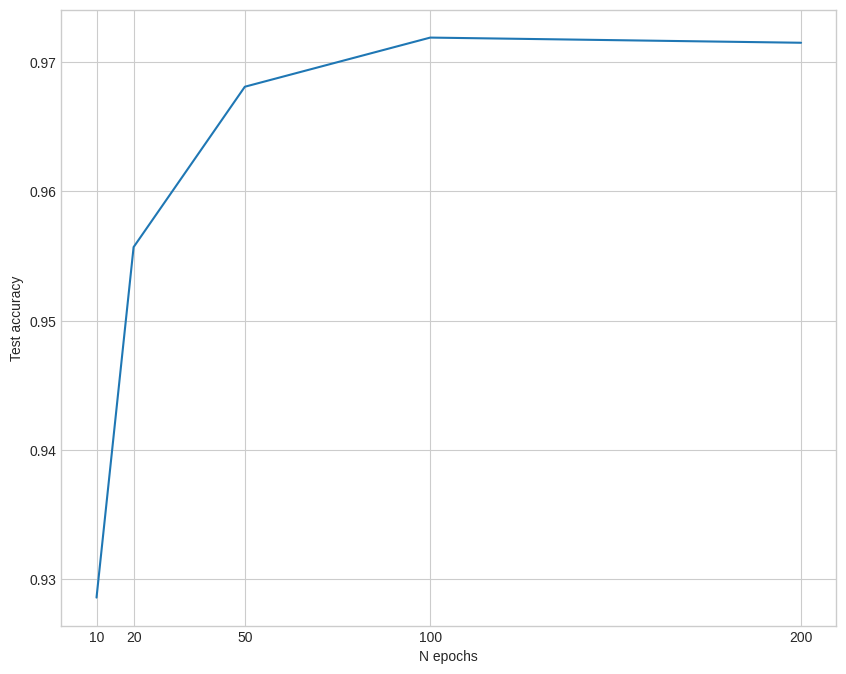

In [104]:
# hidden_dim test accuracy
plt.figure(figsize=(10, 8))
plt.plot(hidden_dims, all_test_acc_hidden_dims)
plt.xlabel('N epochs')
plt.ylabel('Test accuracy')
plt.xticks(hidden_dims)
plt.show()